# 01 - Take samples

In this notebook we will read the json files provided in the **Retail Product Checkout Dataset** and create dataframes for easily accessing the necessary information in the future.

For this project we will ignoe the images in the training sample as they do not fit the project objective. Therefore, whatever is listed as validation will be used as train/validation while the test remains its purpose.

Finally, each image information is listed in the COCO format. More details will be provided as we work on the files.

## Imports and reading the files

In [1]:
import pandas as pd
import numpy as np
import json
import imageio
import matplotlib.pyplot as plt

from funcs.plot import show_image

In [2]:
plt.rcParams['figure.figsize'] = (12,8)

For the project, the json files holds two important informations in these keys:

* annotations: For each unique image id, contains the bounding box parameters for each object in the image as well as other pertinent information. The annotations follow the COCO format, which mean that any bounding box follows [x, y, width, height]

* images: Contains general information about the image, such as its file name, unique id, width and height 


To extract these keys, we first read the json files and pass through a function to transform into Pandas dataframes

In [3]:
with open('data/retail_product/instances_val2019.json') as f:
    val_instances_dict = json.load(f)

# It appears that the test instances has repeated values with the validation, therefore, we will only sample instances from the validation set
# with open('data/retail_product/instances_test2019.json') as f:
#     test_instances_dict = json.load(f)

In [4]:
validation_images = pd.DataFrame(val_instances_dict['images'])
validation_images['file_name'] = 'data/retail_product/val2019/' + validation_images['file_name'] # Computing the full image path
validation_annotations = pd.DataFrame(val_instances_dict['annotations'])

# test_images = pd.DataFrame(val_instances_dict['images'])
# # We have a test folder with images, but the labels are not provided. So, the test annotations given are from a subset of the images found on the validation folder
# test_images['file_name'] = 'data/retail_product/val2019/' + test_images['file_name']

# test_annotations = pd.DataFrame(val_instances_dict['annotations'])

In [5]:
validation_images.head()

file_name  width  height   id level
0  data/retail_product/val2019/20180827-16-07-06-...   1850    1850  220  easy
1  data/retail_product/val2019/20180827-16-07-10-...   1840    1840  221  easy
2  data/retail_product/val2019/20180827-16-24-37-...   1826    1826  222  easy
3  data/retail_product/val2019/20180827-16-24-44-...   1829    1829  223  easy
4  data/retail_product/val2019/20180827-16-24-53-...   1826    1826  224  easy

In [6]:
validation_annotations.head()

area                               bbox  category_id   id  image_id  \
0  145968.80   [519.44, 965.19, 405.05, 360.37]           96  751       220   
1   96655.05   [282.17, 962.21, 278.97, 346.48]          111  752       220   
2   85148.42  [477.74, 1181.62, 236.28, 360.37]           87  753       220   
3   87298.95   [726.93, 1245.15, 343.5, 254.15]           87  754       220   
4   60313.52   [1223.01, 286.82, 171.8, 351.07]           87  755       221   

   iscrowd segmentation           point_xy  
0        0         [[]]  [721.97, 1145.38]  
1        0         [[]]  [421.66, 1135.45]  
2        0         [[]]   [595.88, 1361.8]  
3        0         [[]]  [898.68, 1372.23]  
4        0         [[]]  [1308.91, 462.36]

As an example let's show one image

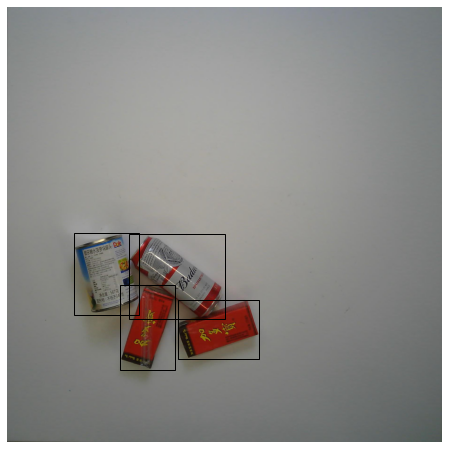

In [7]:
show_image(220, validation_images, True, validation_annotations)

plt.show()

## Taking a random sample

One of the scopes of this work is to apply outlier detection to patches of an image to estimate if that patch contains an object. The **Retail Product Checkout Dataset** is quite sizeful with 6,000 images

In [8]:
validation_images.shape[0]

6000

We can also view a sample of different difficulty levels, as given by the `level` on the images dataframe 

In [9]:
validation_images['level'].value_counts()

easy      2000
medium    2000
hard      2000
Name: level, dtype: int64

The easy images certainly appear to have less clutter and might be more ideal for training the algorithm, while the medium images are a little so-so.

Finally, for the hard images, the objects occupy most of the space and could provide a lot of noise on training. But for the first tests, we will just sample from all the images, ignoring the levels

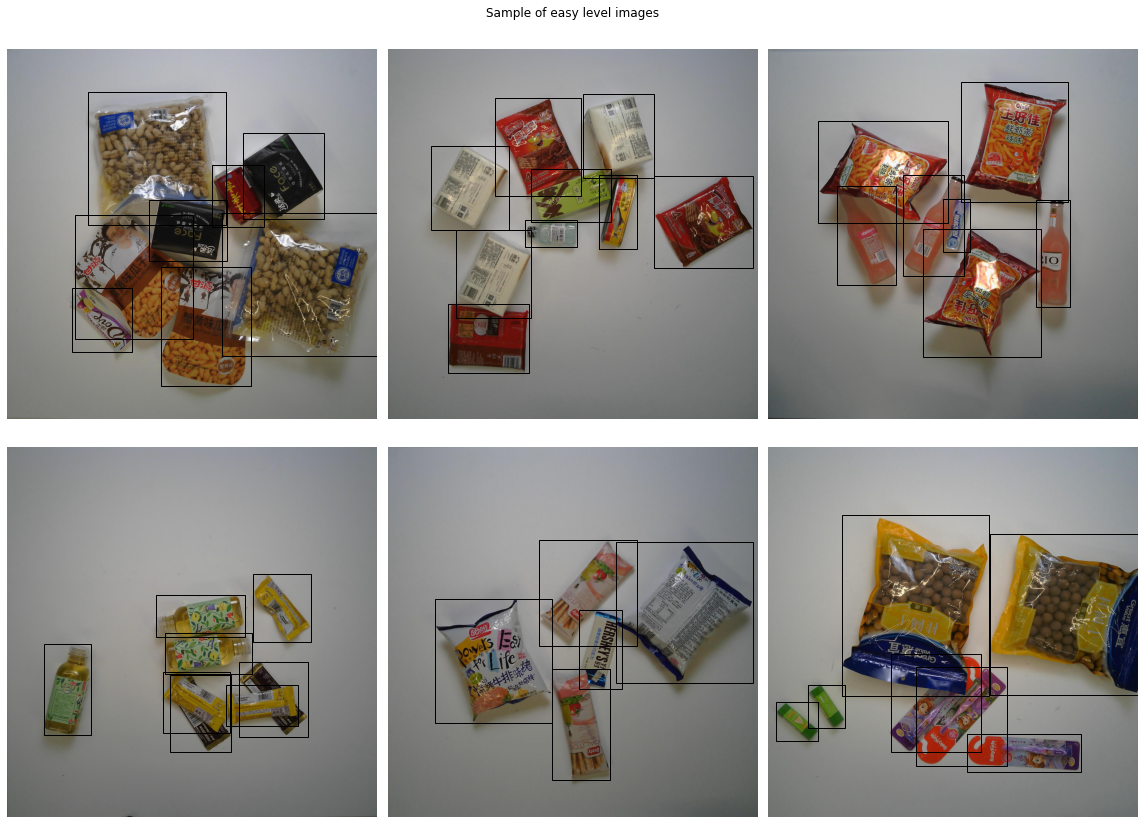

In [17]:
ez_ids = validation_images.loc[validation_images['level']=='easy', 'id'].sample(n=6, replace=False, random_state=99).values
med_ids = validation_images.loc[validation_images['level']=='medium', 'id'].sample(n=6, replace=False, random_state=99).values
hard_ids = validation_images.loc[validation_images['level']=='hard', 'id'].sample(n=6, replace=False, random_state=99).values

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(16,12))

axs = axs.flatten()

for id, ax in zip(ez_ids, axs):

    ax = show_image(id, validation_images, True, validation_annotations, ax=ax)

fig.suptitle('Sample of easy level images')
fig.tight_layout()
plt.show()

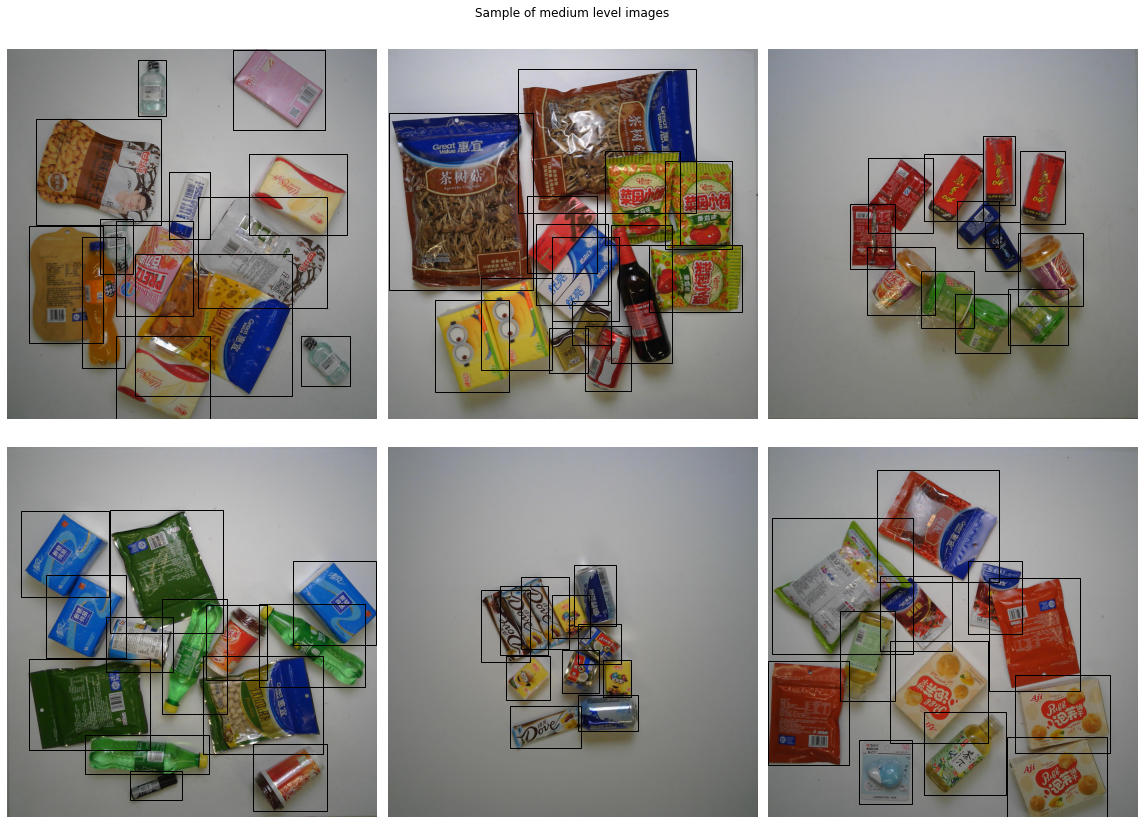

In [18]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(16,12))

axs = axs.flatten()

for id, ax in zip(med_ids, axs):

    ax = show_image(id, validation_images, True, validation_annotations, ax=ax)

fig.suptitle('Sample of medium level images')
fig.tight_layout()
plt.show()

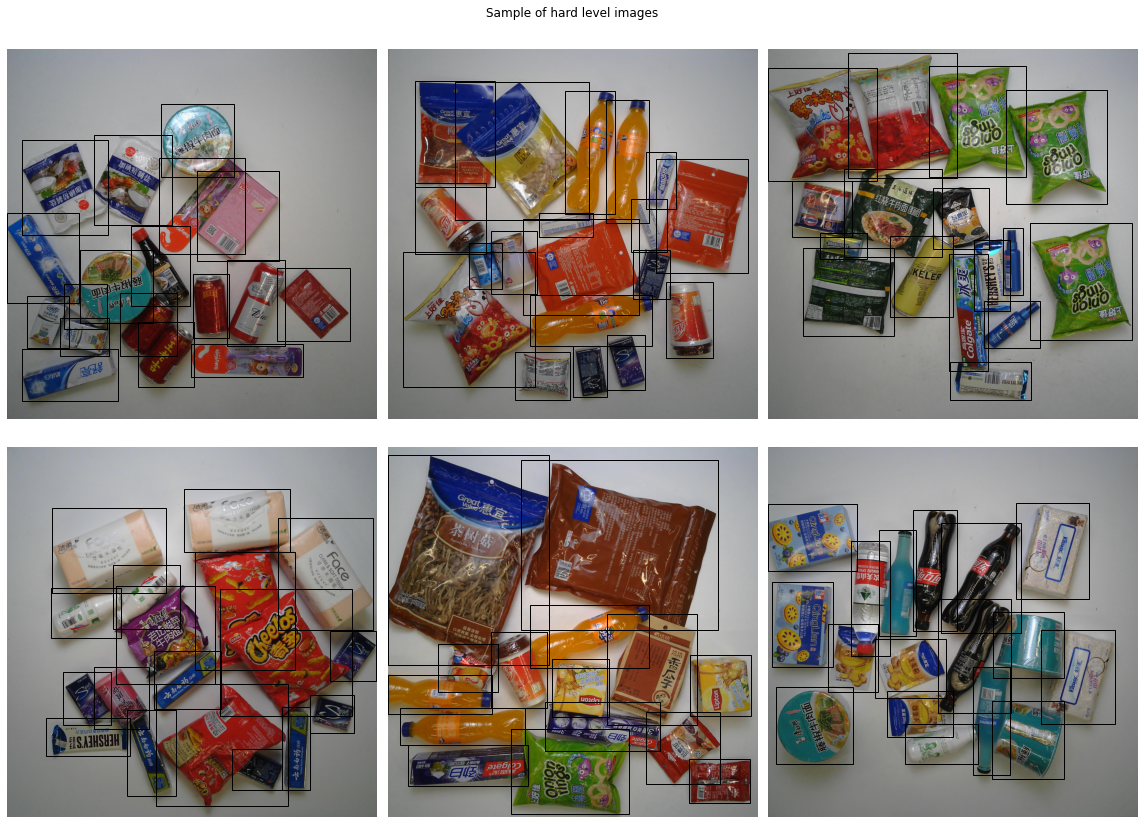

In [19]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(16,12))

axs = axs.flatten()

for id, ax in zip(hard_ids, axs):

    ax = show_image(id, validation_images, True, validation_annotations, ax=ax)

fig.suptitle('Sample of hard level images')
fig.tight_layout()
plt.show()

The images are also fairly large and with a fair amount of pixels, with the average image having 3,352,015 pixels

In [20]:
validation_images['n_pixels'] = validation_images['width']*validation_images['height']

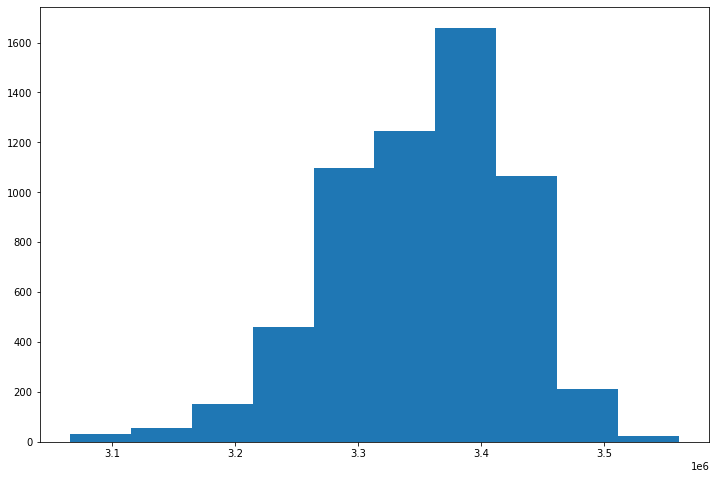

In [24]:
fig, ax = plt.subplots()

ax.hist(validation_images['n_pixels'])

plt.show()

However, they are all square, having the same height and width

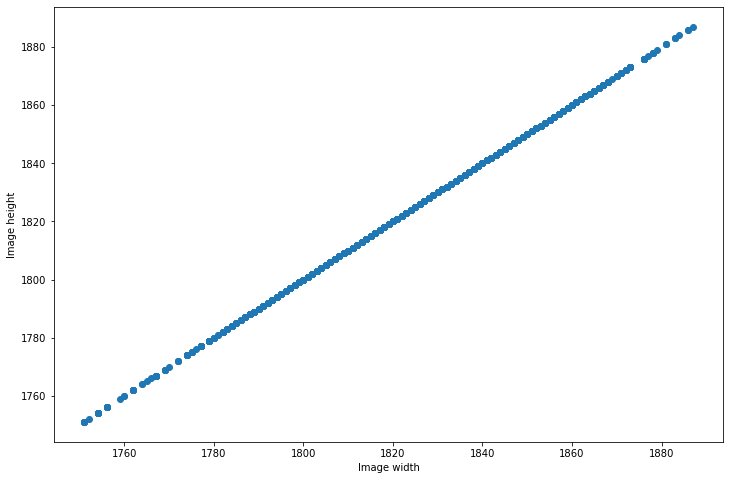

In [25]:
fig, ax = plt.subplots()

ax.scatter(validation_images['width'], validation_images['height'])
ax.set_xlabel('Image width')
ax.set_ylabel('Image height')

plt.show()

In [26]:
validation_images[['width', 'height', 'n_pixels']].describe()

width       height      n_pixels
count  6000.000000  6000.000000  6.000000e+03
mean   1830.739333  1830.739333  3.352015e+06
std      20.213176    20.213176  7.378836e+04
min    1751.000000  1751.000000  3.066001e+06
25%    1817.000000  1817.000000  3.301489e+06
50%    1833.000000  1833.000000  3.359889e+06
75%    1846.000000  1846.000000  3.407716e+06
max    1887.000000  1887.000000  3.560769e+06

Hence, depending on the size of each patch, it would be quite easy to end up with a fairly sizable set of patches, and consequently, a quite lofty amount of data to process.

Therefore, for starters we will take 100 random samples where 70 will be for training and 20 for validation and remaining 10 be for testing which be used as a true out-of-sample to evaluate the final performance of the task.

This number of images was selected as to later on be able to filter for level, or to reliably take sub-samples of smaller sizes for experimentation.

In [27]:
validation_images_sample = validation_images.sample(n=100, replace=False, random_state=1).reset_index(drop=True)

validation_images_sample['source'] = np.where(np.array(validation_images_sample.index) < 70, 'train', 
                                        np.where(np.array(validation_images_sample.index) < 90, 'validation', 'test'))

validation_annotations_sample = validation_annotations.loc[validation_annotations['image_id'].isin(validation_images_sample['id'])]

In [28]:
validation_images_sample['source'].value_counts()

train         70
validation    20
test          10
Name: source, dtype: int64

In [29]:
validation_annotations_sample['image_id'].unique().shape

(100,)

Let's save the dataframes to use later

In [31]:
validation_images_sample.to_pickle('data/retail_product/train_val_images.pkl')
validation_annotations_sample.to_pickle('data/retail_product/train_val_annotations.pkl')